# Spokane Solar Suitability
### Areeba Usman & Rose Martin
---

## Background & Problem Statement

<img src="https://images.unsplash.com/photo-1508514177221-188b1cf16e9d?fm=jpg&q=60&w=3000&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8Mnx8c29sYXIlMjBmYXJtfGVufDB8fDB8fHww" alt="Spokane Map" width="1200"/>

This project aims to predict and classify solar potential as well as determine feasibility in Spokane. 

We will start by identifying relatively flat areas of land that are at least 150 acres and are close to substations which can easily develop and maintain solar farms.

While determining potential will consider cloud cover, elevation, land use, radiation, proximity to substations. Predicting feasibility will consider income, energy costs, and incentives in an area to adopt solar.  

Using this, we will predict areas with solar radiation, classify them by potential, and finally predict the likelihood to adopt solar for the areas with high potential.

---

# Section 0: Install & Importing Packages

## Run data downloads before use

In [ ]:
!pip install -q censusdata

In [5]:
import os
import shutil
import zipfile
import requests
import censusdata
import rasterstats
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import rasterio as rio
import geopandas as gpd
import rioxarray as rxr
from pathlib import Path
import contextily as ctx
from affine import Affine
from scipy.ndimage import label
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
import xyzservices.providers as xyz
from rasterio.features import rasterize
from rasterio import plot, mask, features
from rasterio.transform import from_origin
from matplotlib_scalebar.scalebar import ScaleBar
from shapely.geometry import Point, Polygon, shape, box
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Section 1: Loading Zone
- Introducing data
- Creating AEA Projection

### Census Data 
#### Functions from Lab 5

In [6]:
def get_census_data(tables, state, county, year=2019):
    '''Download census data for a given state and county fips code.'''

    # Download the data
    data = censusdata.download('acs5', year,  # Use 2019 ACS 5-year estimates
                               censusdata.censusgeo([('state', state), ('county', county), ('tract', '*')]),
                               list(tables.keys()))

    # Rename the column
    data.rename(columns=tables, inplace=True)

    # Extract information from the first column
    data['Name'] = data.index.to_series().apply(lambda x: x.name)
    data['SummaryLevel'] = data.index.to_series().apply(lambda x: x.sumlevel())
    data['State'] = data.index.to_series().apply(lambda x: x.geo[0][1])
    data['County'] = data.index.to_series().apply(lambda x: x.geo[1][1])
    data['Tract'] = data.index.to_series().apply(lambda x: x.geo[2][1])
    data.reset_index(drop=True, inplace=True)
    data = data[['Tract','Name']+list(tables.values())].set_index('Tract')
    
    return data

In [7]:
def get_census_tract_geom(state_fips, county_fips):
    '''Download census tract geometries for a given state and county fips code, storing in /tmp and cleaning up after.'''

    temp_dir = "/tmp/census_tracts"
    zip_path = os.path.join(temp_dir, f'tl_2019_{state_fips}_tract.zip')

    # Ensure temp directory exists
    os.makedirs(temp_dir, exist_ok=True)

    # Download the file
    url = f'https://www2.census.gov/geo/tiger/TIGER2019/TRACT/tl_2019_{state_fips}_tract.zip'
    response = requests.get(url, stream=True)
    if response.status_code != 200:
        raise Exception(f"Failed to download file: {url}")

    # Save ZIP file to temp directory
    with open(zip_path, "wb") as file:
        file.write(response.content)

    # Extract the ZIP file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(temp_dir)

    # Find the shapefile in extracted contents
    for file in os.listdir(temp_dir):
        if file.endswith(".shp"):
            shapefile_path = os.path.join(temp_dir, file)
            break

    # Read the shapefile into a GeoDataFrame
    tracts = gpd.read_file(shapefile_path)

    # Filter by county and set index
    tracts = tracts[tracts['COUNTYFP'] == county_fips]
    tracts = tracts.rename(columns={'TRACTCE': 'Tract'}).set_index('Tract')

    # Cleanup: Remove extracted files and ZIP file
    shutil.rmtree(temp_dir)

    return tracts[['geometry']]

In [8]:
tables = {
'B19013_001E': 'MedianIncome',
'B01003_001E': 'TotalPopulation',
'B25064_001E': 'MedianGrossRent',
'B25077_001E': 'MedianHomeValue',
'B25035_001E': 'MedianYearStructureBuilt',
'B25001_001E': 'TotalHousingUnits',
'B25004_001E': 'TotalVacantHousingUnits',
'B25003_002E': 'OccupiedHousingUnitsOwnerOccupied',
'B25003_003E': 'OccupiedHousingUnitsRenterOccupied',
}

## FIPS Code for Washington
state_fips = '53' 

## FIPS code for Spokane County
county_fips = '063'  

In [9]:
## Data
census_df = get_census_data(tables, state_fips, county_fips)
## Geometry
tract_geom_gdf = get_census_tract_geom(state_fips, county_fips)
## Projection Placeholder
tract_geom_gdf_fo_proj = tract_geom_gdf

# Joining geometries to spokane census data
census_Spokane_gdf = gpd.GeoDataFrame(census_df.join(tract_geom_gdf))
census_Spokane_gdf =  census_Spokane_gdf.to_crs('epsg:32610')
census_df.head()

,Name,MedianIncome,TotalPopulation,MedianGrossRent,MedianHomeValue,MedianYearStructureBuilt,TotalHousingUnits,TotalVacantHousingUnits,OccupiedHousingUnitsOwnerOccupied,OccupiedHousingUnitsRenterOccupied
Tract,,,,,,,,,,
014500,"Census Tract 145, Spokane County, Washington",26250,1954,693,126100,1941,952,161,214,577
012100,"Census Tract 121, Spokane County, Washington",51223,2627,1000,161500,1958,1235,53,824,358
002100,"Census Tract 21, Spokane County, Washington",54620,2483,843,145500,0,1109,16,617,476
010301,"Census Tract 103.01, Spokane County, Washington",52531,4795,784,199000,1983,1890,115,1435,340
011102,"Census Tract 111.02, Spokane County, Washington",40671,4527,853,181000,1980,1732,74,457,1201


## State Data

In [10]:
states_url = 'http://eric.clst.org/assets/wiki/uploads/Stuff/gz_2010_us_040_00_500k.json'
states_gdf = gpd.read_file(states_url)
states_gdf.head()

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry
0,0400000US23,23,Maine,,30842.923,"MULTIPOLYGON (((-67.61976 44.51975, -67.61541 ..."
1,0400000US25,25,Massachusetts,,7800.058,"MULTIPOLYGON (((-70.83204 41.6065, -70.82374 4..."
2,0400000US26,26,Michigan,,56538.901,"MULTIPOLYGON (((-88.68443 48.11578, -88.67563 ..."
3,0400000US30,30,Montana,,145545.801,"POLYGON ((-104.0577 44.99743, -104.25014 44.99..."
4,0400000US32,32,Nevada,,109781.180,"POLYGON ((-114.0506 37.0004, -114.05 36.95777,..."


In [11]:
## 32048 is the EPSG recommended for Spokane County
states_proj_gdf = states_gdf.to_crs(4326)

WA_idx = states_proj_gdf["NAME"].isin(["Washington"])
wa_state_gdf = states_proj_gdf[WA_idx]

## AEA Projection Around Spokane

In [12]:
hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull
cent = hull.centroid

cent_lon =cent.x
cent_lat = cent.y
min_lat = tract_geom_gdf_fo_proj.bounds["miny"].min().item()
max_lat = tract_geom_gdf_fo_proj.bounds["maxy"].max().item()

/tmp/ipykernel_1066/2544106682.py:1: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  hull = tract_geom_gdf_fo_proj.geometry.unary_union.convex_hull


In [13]:
proj_str_aea = f'+proj=aea +lat_1={min_lat:0.2f} +lat_2={max_lat:0.2f} +lat_0={cent_lat:0.2f} +lon_0={cent_lon:0.2f}'
print(proj_str_aea)

+proj=aea +lat_1=47.26 +lat_2=48.05 +lat_0=47.64 +lon_0=-117.42


## Flood Plains Data

In [14]:
floodplains_fn = './Data/FEMA_Flood_Zone.geojson'
floodplains_gdf = gpd.read_file(floodplains_fn)

In [15]:
floodplains_gdf = floodplains_gdf.set_crs(4326)
floodplains_gdf.head()

,OBJECTID,FLD_ZONE,FloodZone,FloodDescription,ShapeSTArea,ShapeSTLength,geometry
0,1,AE,100 Year,1 Percent Annual Chance Flood Zone,2563.373517,1057.303252,"POLYGON ((-117.21347 47.71921, -117.21342 47.7..."
1,2,AE,100 Year,1 Percent Annual Chance Flood Zone,47091.207776,1316.843587,"POLYGON ((-117.39354 47.5726, -117.3937 47.572..."
2,3,X,500 Year,0.2 Percent Annual Chance Flood Zone,12072.635706,1139.022057,"POLYGON ((-117.41693 47.66159, -117.41703 47.6..."
3,4,AE,100 Year,1 Percent Annual Chance Flood Zone,3293.344152,385.964150,"POLYGON ((-117.33046 47.92931, -117.33022 47.9..."
4,5,X,500 Year,0.2 Percent Annual Chance Flood Zone,140930.032756,2078.807675,"POLYGON ((-117.78801 47.42675, -117.78808 47.4..."


### Binary Flood Plain Raster

In [16]:
floodplain_buffer_fn = "./Data/floodplain_with_buffer.tif"
floodplain_buffer_data = rxr.open_rasterio(floodplain_buffer_fn).squeeze()

## Slope Data

In [30]:
slope_fn = "./Data/WA_COP90_utm_gdalwarp_slope.tif"
slope_ras = rxr.open_rasterio(slope_fn, masked=True).squeeze()

## Substation Distance Data

In [31]:
substation_distance_raster_fn = "./Data/distance_raster_proj_alt.tif"
substation_distance_raster_data = rxr.open_rasterio(substation_distance_raster_fn).squeeze()

## Radiation Data

In [32]:
radiation_fn = "./Data/radiation.tif"
radiation = rxr.open_rasterio(radiation_fn).squeeze()

## Land Use Data

In [33]:
dst_crs = 'EPSG:4326'
land_use_fn = "./Data/land_use.tif"
land_use_da = rxr.open_rasterio(land_use_fn).squeeze()

---

# Section 2A: Data Prep
- Reprojecting to AEA Proj
- Clipping data to remove protected places
- Resolution match

### CRS Projection Match to Spokane AEA 

In [34]:
slope_ras = slope_ras.rio.reproject(proj_str_aea)

land_use_da = land_use_da.rio.reproject(proj_str_aea)

radiation = radiation.rio.reproject(proj_str_aea)

census_Spokane_gdf = census_Spokane_gdf.to_crs(proj_str_aea)

tract_geom_gdf = tract_geom_gdf.to_crs(proj_str_aea)

floodplains_gdf = floodplains_gdf.to_crs(proj_str_aea)

census_geom = census_Spokane_gdf.geometry.unary_union

/tmp/ipykernel_1066/1381714990.py:13: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  census_geom = census_Spokane_gdf.geometry.unary_union


### Clipping all data to available land in Spokane

In [35]:
slope = slope_ras.rio.clip([census_geom])

land_use = land_use_da.rio.clip([census_geom])

radiation = radiation.rio.clip([census_geom])

substation_distance = substation_distance_raster_data.rio.clip([census_geom])

floodplain_buffer = floodplain_buffer_data.rio.clip([census_geom])

### Matching Resolutions

In [36]:
print(radiation.rio.resolution(), 
      slope.rio.resolution(), 
      land_use.rio.resolution(),
      substation_distance.rio.resolution(),
      floodplain_buffer.rio.resolution())

(748.2422257325958, -748.2422257325958) (68.72899148091128, -68.72899148091122) (93.53027821657551, -93.53027821657551) (100.0, -100.0) (100.0, -100.0)


In [37]:
land_use = land_use_da.rio.reproject_match(floodplain_buffer_data)

radiation = radiation.rio.reproject_match(floodplain_buffer_data)

slope = slope.rio.reproject_match(floodplain_buffer_data)

In [38]:
print(radiation.rio.resolution(), 
      slope.rio.resolution(), 
      land_use.rio.resolution(),
      substation_distance.rio.resolution(),
      floodplain_buffer.rio.resolution())

(100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0) (100.0, -100.0)


# What does all of this look like so far?

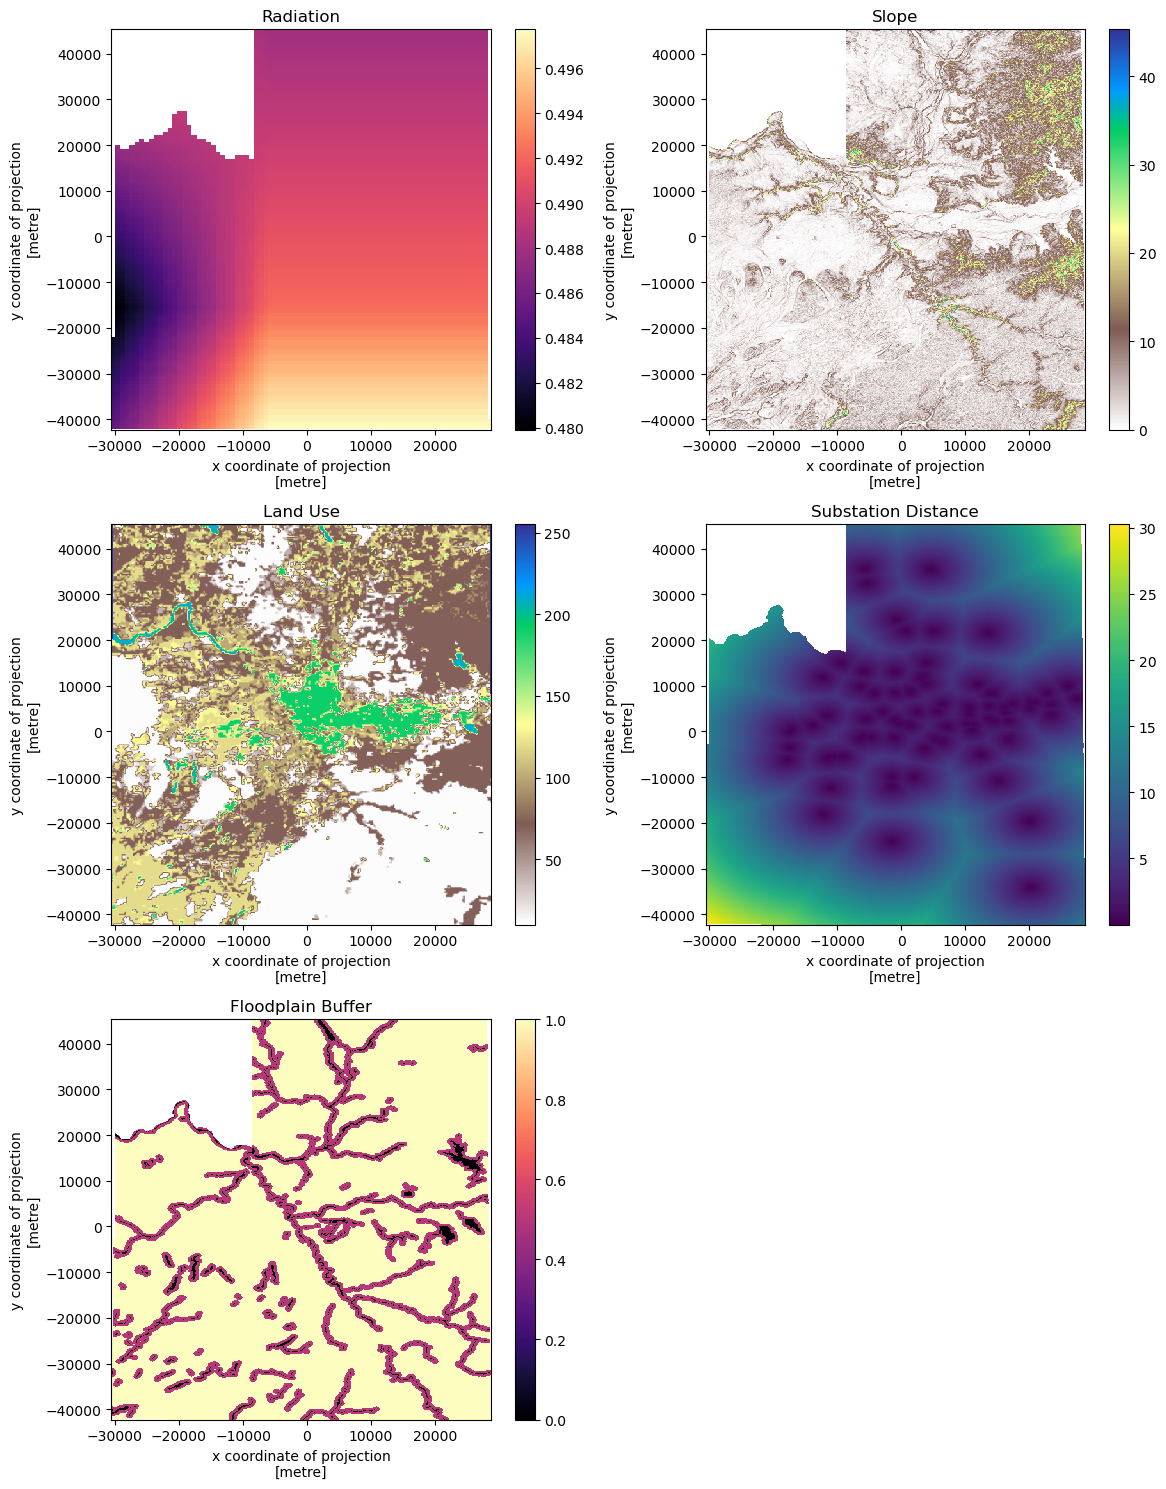

In [39]:
ds = [radiation, slope, land_use, substation_distance, floodplain_buffer]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['magma', 'terrain_r', 'terrain_r', 'viridis', 'magma']

n_rows = (len(ds) + 1) // 2

fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 5))

axs = axs.flatten()

for i, (data, title, cmap) in enumerate(zip(ds, titles, cmap)):
    data.plot(ax=axs[i], cmap=cmap)
    axs[i].set_title(title)
    axs[i].axis('on')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

---
# Section 2B
- Merging all data to XDarray Datafrane
- Summary Table

In [40]:
floodplain_buffer.name = 'Flood_Zones'
substation_distance.name = 'Substation_Distance'
radiation.name = 'Radiation'
land_use.name = 'Land_Use'
slope.name = 'Slope'

merged_df = xr.merge([floodplain_buffer, 
                      slope, 
                      substation_distance, 
                      radiation, 
                      land_use])

In [41]:
merged_df

<xarray.Dataset> Size: 11MB
Dimensions:              (x: 593, y: 876)
Coordinates:
    band                 int64 8B 1
  * x                    (x) float64 5kB -3.05e+04 -3.04e+04 ... 2.87e+04
  * y                    (y) float64 7kB 4.53e+04 4.52e+04 ... -4.22e+04
    spatial_ref          int64 8B 0
Data variables:
    Flood_Zones          (y, x) float32 2MB nan nan nan nan ... 1.0 1.0 1.0 1.0
    Slope                (y, x) float32 2MB nan nan nan nan ... 1.893 3.11 3.329
    Substation_Distance  (y, x) float32 2MB nan nan nan ... 11.57 11.64 11.71
    Radiation            (y, x) float64 4MB nan nan nan nan ... nan nan nan nan
    Land_Use             (y, x) uint8 519kB 255 255 255 113 69 ... 11 11 11 11
Attributes:
    AREA_OR_POINT:  Area
    scale_factor:   1.0
    add_offset:     0.0

In [42]:
summary_table = merged_df.mean()
summary_table = merged_df.to_dataframe().describe()

In [43]:
summary_table

,band,spatial_ref,Flood_Zones,Slope,Substation_Distance,Radiation,Land_Use
count,519468.0,519468.0,461258.000000,460998.000000,461258.000000,458396.000000,519468.000000
mean,1.0,0.0,0.883075,4.543242,7.277742,0.490318,68.185367
std,0.0,0.0,0.242088,4.954040,5.613572,0.003321,49.098074
min,1.0,0.0,0.000000,0.000000,0.001652,0.479920,10.000000
25%,1.0,0.0,1.000000,1.227909,2.873534,0.488473,11.000000
50%,1.0,0.0,1.000000,2.754481,5.769769,0.490086,70.000000
75%,1.0,0.0,1.000000,5.875230,10.252606,0.492004,100.000000
max,1.0,0.0,1.000000,45.333660,30.263113,0.497737,255.000000


---
# Section 3: Scales & Classes 

In [44]:
scale = merged_df.copy()

### Land Use

In [45]:
original_values = merged_df["Land_Use"]

scale['Land_Use'] = xr.where((original_values >= 150) & (original_values <= 180) | (original_values >= 210), np.nan, scale['Land_Use'])  # Water/Snow
scale['Land_Use'] = xr.where((original_values == 190), np.nan, scale['Land_Use'])  # Urban Areas
scale['Land_Use'] = xr.where((original_values >= 10) & (original_values <= 20), 3, scale['Land_Use'])  # Farmland 
scale['Land_Use'] = xr.where((original_values >= 50) & (original_values <= 90) | (scale['Land_Use'] == 100), np.nan, scale['Land_Use'])  # Forests
scale['Land_Use'] = xr.where((original_values == 200), 6, scale['Land_Use'])  # Bare Areas
scale['Land_Use'] = xr.where((original_values == 30) | (original_values >= 110) & (scale['Land_Use'] <= 140), 5, scale['Land_Use']) # Grasslands

### Flood Zones

In [46]:
# Creates the scale for the substation distancce. Based on how far the substation is from each pixel
scale["Flood_Zones"] = merged_df.Flood_Zones * 6
# Always reference original values from merged_df, ensuring that things are not being overwritten in the original
original_values = merged_df["Substation_Distance"]

# Only update values in scale without overwriting previous changes
scale["Substation_Distance"] = xr.where(original_values <= 2.5, 6, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 2.5) & (original_values <= 5), 5, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 5) & (original_values <= 7.5), 4, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values >= 7.5) & (original_values < 10), 3, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 10) & (original_values <= 15), 2, scale["Substation_Distance"])
scale["Substation_Distance"] = xr.where((original_values > 15), 1, scale["Substation_Distance"])

### Slope

In [47]:
original_values = merged_df["Slope"]

# Slope is ranked by the best, 6, being the lowest slopes, and the worst, one being the steepest
scale["Slope"] = xr.where(original_values <= 5, 6, scale["Slope"])
scale["Slope"] = xr.where((original_values > 5) & (original_values <= 10), 5, scale["Slope"])
scale["Slope"] = xr.where((original_values > 10) & (original_values <= 15), 4, scale["Slope"])

#Any slope above 15 too steep and gets a value of one
scale["Slope"] = xr.where(original_values >= 15, 1, scale["Slope"])

### Radiation

In [48]:
min_value = merged_df["Radiation"].min().item()
max_value = merged_df["Radiation"].max().item()
range_values = (max_value - min_value)/ 6

In [49]:
original_values = merged_df["Radiation"]

# Values seperated ransomly as the values are all within range for what is desired from a solar farm
scale["Radiation"] = xr.where((original_values > (max_value-range_values)) & (original_values <= max_value), 6, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value-range_values*2)) & (original_values <= (max_value - range_values)), 5, scale["Radiation"])
scale["Radiation"] = xr.where((original_values > (max_value - range_values*3)) & (original_values <= (max_value - 2*range_values)), 4, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+ 2* range_values)) & (original_values <= (min_value + 3*range_values)), 3, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value+range_values)) & (original_values <= (min_value + 2*range_values)), 2, scale["Radiation"])
scale["Radiation"] = xr.where((original_values >= (min_value)) & (original_values <= (min_value + range_values)), 1, scale["Radiation"])

## Removing areas where land use and flood zones are nan

In [50]:
## removes all the spots that are ether nan or 0 as those are the areas that are either outside the county border 
##    or have been marksed as flood plains. Removes these points from every raster.
scale = scale.where((scale.Flood_Zones.notnull()) & (scale.Flood_Zones != 0), drop=True)
scale = scale.where((scale.Land_Use.notnull()) & (scale.Land_Use != 0), drop=True)
#scale = scale.where(scale.Land_Use != 0, drop=True)

# How we lookin

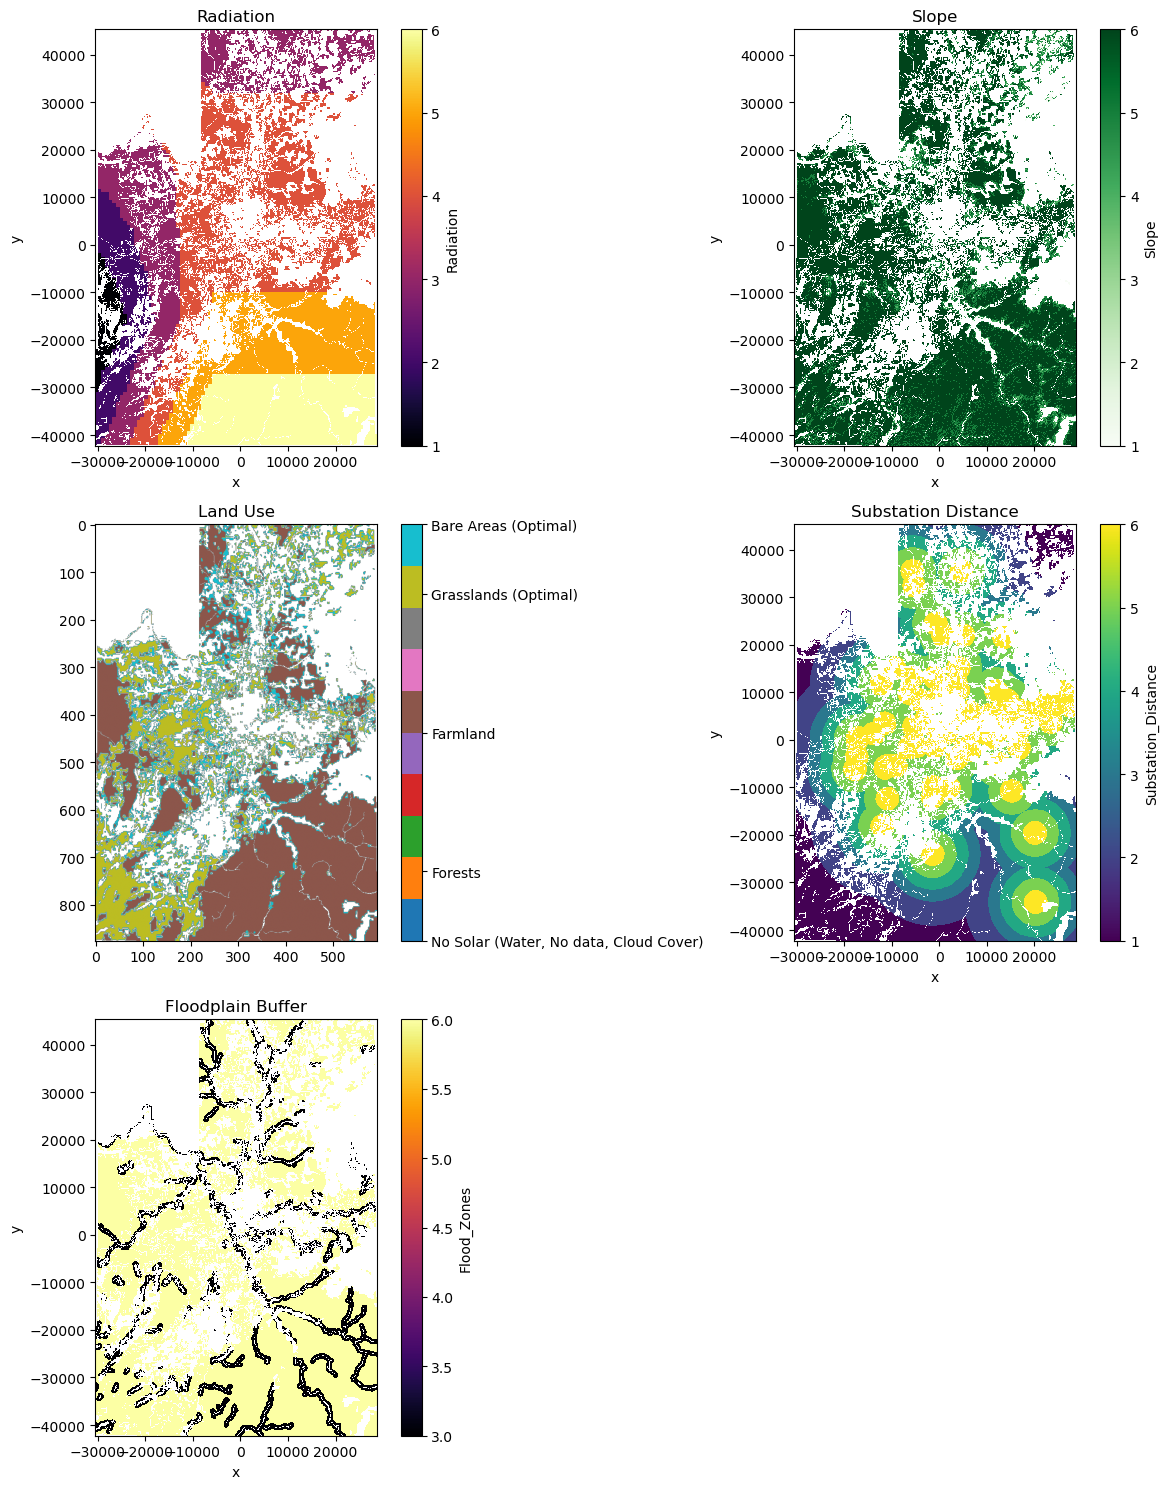

In [51]:
land_use_labels = {
    0: "No Solar (Water, No data, Cloud Cover)",
    1: "Forests",
    3: "Farmland",
    5: "Grasslands (Optimal)",
    6: "Bare Areas (Optimal)"
}
land_use_plot = scale["Land_Use"]

# Update the dataset to use numeric values for Land_Use
ds = [scale["Radiation"], scale["Slope"], land_use_plot, scale["Substation_Distance"], scale["Flood_Zones"]]
titles = ['Radiation', 'Slope', 'Land Use', 'Substation Distance', 'Floodplain Buffer']
cmap = ['inferno', 'Greens', 'Dark2', 'viridis', 'inferno']

n_rows = (len(ds) + 1) // 2
fig, axs = plt.subplots(n_rows, 2, figsize=(12, n_rows * 5))

axs = axs.flatten()

for i, (data, title, colormap) in enumerate(zip(ds, titles, cmap)):
    if title == "Land Use":
        im = axs[i].imshow(data, cmap='tab10', vmin=0, vmax=6)  # Adjust colormap for categorical data
        cbar = fig.colorbar(im, ax=axs[i], ticks=list(land_use_labels.keys()))
        cbar.ax.set_yticklabels(list(land_use_labels.values()))
    else:
        data.plot(ax=axs[i], cmap=colormap)
    axs[i].set_title(title)
    axs[i].set_aspect('equal')
    axs[i].axis('on')

# Remove any unused subplots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

# Section 4: Score Weight Calculation

In [52]:
# It was determined that the score would be weighted based on the importance/influence of the variable
# The weight was based on what we thoguht was most important but was also somewhat arbitrary

# score = land use * 1 + substatin distacne * 1 + radiation * 0 .75 + slope * 1.25

net_score_unweighted = scale["Radiation"] + scale["Slope"] + scale["Substation_Distance"] + scale["Flood_Zones"]
net_score_weighted = scale["Radiation"] * 0.75 + scale["Slope"] * 1.25 + scale["Substation_Distance"] * 1 + scale["Flood_Zones"] * 0.25

scale["net_score_weighted"] = net_score_weighted
scale['net_score_unweighted']= net_score_unweighted

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='x', ylabel='y'>

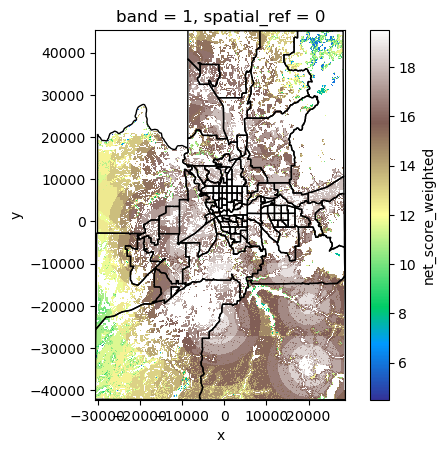

In [54]:
fig,ax = plt.subplots()
scale.net_score_weighted.plot(ax=ax, cmap='terrain')
tract_geom_gdf.plot(ax=ax, edgecolor="black", facecolor = 'none')

#substation_gdf.plot(ax=ax, color='red', edgecolor='k',alpha=0.7)

# Section 5: Finding 200 acre-ft areas

In [55]:
net_score_unweighted

<xarray.DataArray (y: 876, x: 593)> Size: 4MB
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [15., 15., 15., ..., 20., 20., 20.],
       [15., 15., 15., ..., 20., 20., 20.],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
    band         int64 8B 1
  * x            (x) float64 5kB -3.05e+04 -3.04e+04 ... 2.86e+04 2.87e+04
  * y            (y) float64 7kB 4.53e+04 4.52e+04 ... -4.21e+04 -4.22e+04
    spatial_ref  int64 8B 0

In [56]:
data = net_score_unweighted.values
pixel_size = 100  # meters

## Note: Cange the desired area size, in acres
area = 150

#Conversion of acres to m^2
acre_in_m2 = 4046.86

# side length in meters (~636.37 m)
cell_area_m2 = area * acre_in_m2       
cell_side = np.sqrt(cell_area_m2)     

In [57]:
# Get the raster bounds based on the xarray coordinates.
x_coords = net_score_unweighted.coords['x'].values
y_coords = net_score_unweighted.coords['y'].values

In [58]:
# Assuming x and y are pixel center coordinates, compute the full extent:
x_min = x_coords[0] - pixel_size/2
x_max = x_coords[-1] + pixel_size/2
if y_coords[0] > y_coords[-1]:
    # y is descending (common in rasters)
    y_max = y_coords[0] + pixel_size/2
    y_min = y_coords[-1] - pixel_size/2
else:
    y_min = y_coords[0] - pixel_size/2
    y_max = y_coords[-1] + pixel_size/2

In [59]:
# Set up the affine transform for the raster.
# (This assumes the raster is north-up; adjust if your coordinate system is different.)
if y_coords[0] > y_coords[-1]:
    transform = Affine(pixel_size, 0, x_min,
                       0, -pixel_size, y_max)
else:
    transform = Affine(pixel_size, 0, x_min,
                       0, pixel_size, y_min)

In [60]:
# Build a grid covering the raster extent with cells of size "cell_side" x "cell_side".
grid_polygons = []
current_x = x_min
while current_x < x_max:
    current_y = y_min
    while current_y < y_max:
        # Create a polygon for this grid cell.
        cell_poly = box(current_x, current_y, current_x + cell_side, current_y + cell_side)
        grid_polygons.append(cell_poly)
        current_y += cell_side
    current_x += cell_side

In [61]:
# A helper function to compute pixel window indices for a given real-world bounding box.
def get_window_indices(xmin, xmax, ymin, ymax, transform, shape):
    inv_transform = ~transform
    # For a box, compute the indices for the top-left and bottom-right corners.
    col_min, row_min = map(int, inv_transform * (xmin, ymax))
    col_max, row_max = map(int, inv_transform * (xmax, ymin))
    # Clamp indices to the data array bounds.
    row_min = max(0, row_min)
    row_max = min(shape[0], row_max + 1)
    col_min = max(0, col_min)
    col_max = min(shape[1], col_max + 1)
    return row_min, row_max, col_min, col_max

In [62]:
# Loop over each grid cell. For each, we extract the subset of pixel values
# that lie within its bounding box and then verify (using the pixel center coordinates)
# that every pixel falling inside the cell is non-NaN.
cells = []
net_scores = []
for poly in grid_polygons:
    # Get the bounds of the polygon.
    xmin, ymin, xmax, ymax = poly.bounds
    # Get corresponding pixel indices.
    row_min, row_max, col_min, col_max = get_window_indices(xmin, xmax, ymin, ymax, transform, data.shape)
    if row_max <= row_min or col_max <= col_min:
        continue
    window_data = data[row_min:row_max, col_min:col_max]
    
    # Build a grid of pixel center coordinates for the window.
    rows, cols = np.indices(window_data.shape)
    # Compute real-world coordinates for each pixel center.
    xs, ys = transform * (cols + col_min + 0.5, rows + row_min + 0.5)
    
    # Create a mask: True for pixels whose center falls within the polygon.
    # (Note: This approach iterates over each pixel center.)
    inside = np.array([poly.contains(Point(x, y)) for x, y in zip(xs.ravel(), ys.ravel())])
    inside_mask = inside.reshape(window_data.shape)
    
    # If any pixel within the cell is NaN, skip this cell.
    if np.isnan(window_data[inside_mask]).any():
        continue
    
    # Sum the net score for pixels whose centers lie within the cell.
    cell_net_score = np.sum(window_data[inside_mask])
    cells.append(poly)
    net_scores.append(cell_net_score)

In [63]:
# Create a GeoDataFrame with the resulting grid cells and net score sums.
gdf = gpd.GeoDataFrame({'net_score': net_scores, 'geometry': cells}, crs=proj_str_aea)
gdf

,net_score,geometry
0,958.0,"POLYGON ((-28990.662 -39136.554, -28990.662 -3..."
1,960.0,"POLYGON ((-28990.662 -36020.071, -28990.662 -3..."
2,748.0,"POLYGON ((-28990.662 -33682.709, -28990.662 -3..."
3,958.0,"POLYGON ((-28990.662 -32903.589, -28990.662 -3..."
4,960.0,"POLYGON ((-28990.662 -32124.468, -28990.662 -3..."
...,...,...
1774,1232.0,"POLYGON ((27885.146 8389.806, 27885.146 9168.9..."
1775,1280.0,"POLYGON ((28664.266 -41473.916, 28664.266 -406..."
1776,1132.0,"POLYGON ((28664.266 -40694.795, 28664.266 -399..."
1777,159.0,"POLYGON ((29443.387 -41473.916, 29443.387 -406..."


Text(0.5, 1.0, 'Optimal Land Parcels')

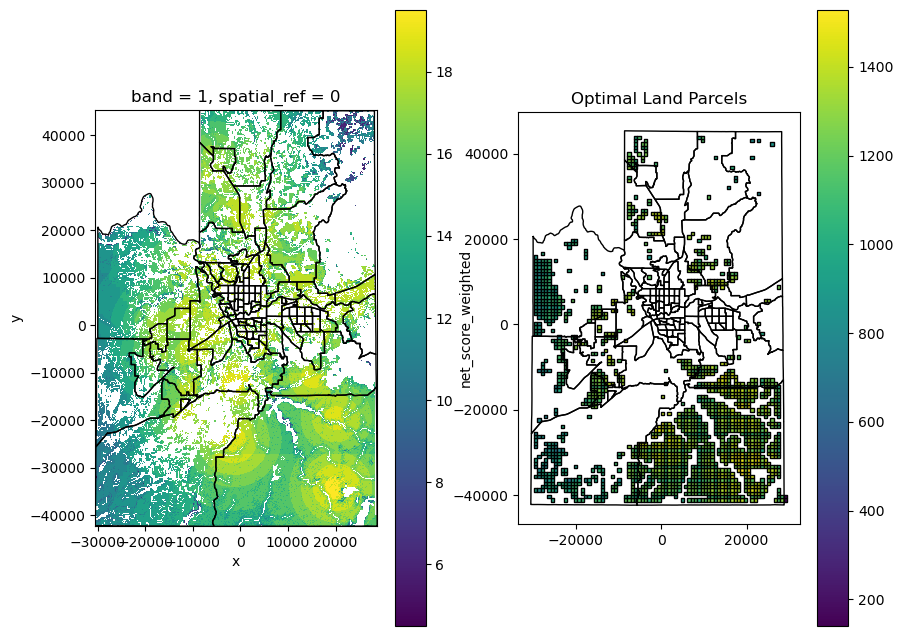

In [64]:
fig, ax = plt.subplots(1,2,figsize=(10, 8))

scale.net_score_weighted.plot(ax=ax[0])
tract_geom_gdf.plot(ax=ax[0], facecolor = 'none')

gdf.plot(column="net_score", cmap="viridis", edgecolor="black", legend=True, ax=ax[1])
#scale.net_score_weighted.plot(ax=ax[1])

tract_geom_gdf.plot(ax=ax[1], edgecolor="black", facecolor = 'none')
ax[1].set_title("Optimal Land Parcels")

In [65]:
gdf_filter_id =  gdf.net_score > 1450
gdf_filter = gdf[gdf_filter_id]

gdf_filter

,net_score,geometry
605,1454.0,"POLYGON ((-4058.801 -28228.865, -4058.801 -274..."
663,1460.0,"POLYGON ((-1721.439 -29007.985, -1721.439 -282..."
682,1459.0,"POLYGON ((-942.319 -29007.985, -942.319 -28228..."
709,1469.0,"POLYGON ((-163.198 -25112.382, -163.198 -24333..."
732,1456.0,"POLYGON ((615.923 -25112.382, 615.923 -24333.2..."
733,1465.0,"POLYGON ((615.923 -24333.261, 615.923 -23554.1..."
734,1470.0,"POLYGON ((615.923 -23554.141, 615.923 -22775.0..."
1279,1472.0,"POLYGON ((14640.094 -12646.452, 14640.094 -118..."
1316,1452.0,"POLYGON ((15419.215 -13425.572, 15419.215 -126..."
1317,1472.0,"POLYGON ((15419.215 -12646.452, 15419.215 -118..."


In [66]:
tract_geom_gdf_fil = tract_geom_gdf.clip(gdf_filter.geometry)

tract_geom_gdf_fil.head()

for index in (tract_geom_gdf_fil.index):
    print(str(index))
    print(tract_geom_gdf.loc[str(index)])
    tract_geom_gdf_fil.loc[str(index)].geometry = tract_geom_gdf.loc[str(index)].geometry

#tract_geom_gdf_fil.iloc[2].total_bounds()

014300
geometry    POLYGON ((-5845.299 -41537.135, -5844.419 -414...
Name: 014300, dtype: geometry
013300
geometry    POLYGON ((5278.643 -13761.158, 5281.747 -13612...
Name: 013300, dtype: geometry
014200
geometry    POLYGON ((-30548.75 -42129.911, -30548.737 -42...
Name: 014200, dtype: geometry


/tmp/ipykernel_1066/3375783060.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tract_geom_gdf_fil.loc[str(index)].geometry = tract_geom_gdf.loc[str(index)].geometry


# Section 6: Identified Parcels of Land

Text(0.5, 1.0, 'Optimal Land Parcels')

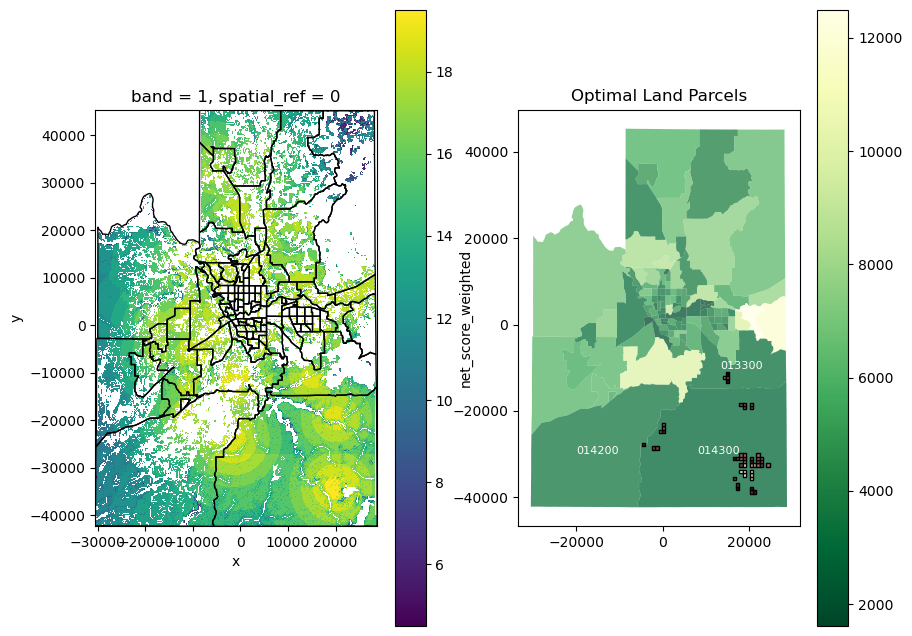

In [67]:
fig, ax = plt.subplots(1,2,figsize=(10, 8))

scale.net_score_weighted.plot(ax=ax[0])
tract_geom_gdf.plot(ax=ax[0], facecolor = 'none')

census_Spokane_gdf.plot(ax=ax[1], column="TotalPopulation",cmap="YlGn_r", legend=True, alpha=0.75)
gdf_filter.plot(column="net_score", cmap="pink", edgecolor="black", ax=ax[1])
#scale.net_score_weighted.plot(ax=ax[1])

for x, y, label in zip(tract_geom_gdf_fil.geometry.centroid.x, 
                        tract_geom_gdf_fil.geometry.centroid.y, 
                        tract_geom_gdf_fil.index):
    ax[1].text(x, y, label, fontsize=8, ha='center', va='center', color='white')

ax[1].set_title("Optimal Land Parcels")

<Axes: ylabel='Frequency'>

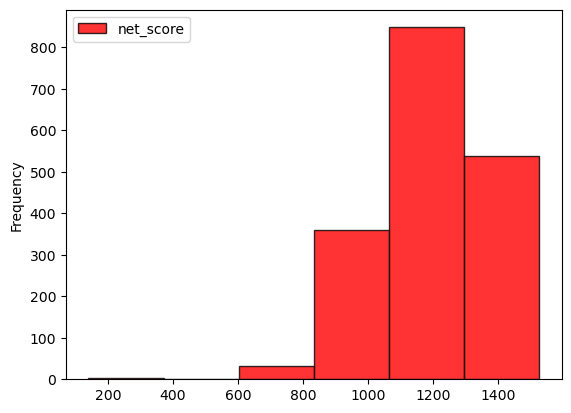

In [68]:
gdf.plot.hist(facecolor='red', edgecolor='black', alpha=0.8, bins=6)

In [69]:
solar_lands_itin_coord = gdf_filter.to_crs(4326)
solar_lands_itin_coord.head()

,net_score,geometry
605,1454.0,"POLYGON ((-117.47376 47.38609, -117.47376 47.3..."
663,1460.0,"POLYGON ((-117.4428 47.37909, -117.4428 47.386..."
682,1459.0,"POLYGON ((-117.43248 47.3791, -117.43248 47.38..."
709,1469.0,"POLYGON ((-117.42216 47.41414, -117.42216 47.4..."
732,1456.0,"POLYGON ((-117.41184 47.41414, -117.41184 47.4..."


# Section  7: Conclusion

In [ ]:
Future direction 